# Predictive modeling of `SalePrice` in Ames housing dataset

In a previous notebook we [processed and cleaned](process.ipynb/#Processing-the-Ames-housing-dataset) the Ames dataset, and in another we [explored the data and selected/engineered some new features](explore.ipynb/#Exploratory-analysis-of-Ames-housing-dataset).

In this notebook, we'll model and predict `SalePrice`. First we'll do a little feature selection and engineering to create a few different versions of the data for modeling. Then we'll compare the prediction performance of some appropriate models on these versions, select a subset of these versions and models for fine-tuning, ensemble them to maximize predictive generalizablity, and test them by submitting to Kaggle.

## Setup

In [1]:
%matplotlib inline
import warnings
import os
import sys

# add parent directory for importing custom classes
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(pardir)

# import custom classes
from codes.model import *
from codes.explore import plot_cont_dists

warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')
sns.set_style('white')

## Load and prepare data

In [2]:
hp_data = load_datasets(data_dir='../data', file_names=['clean.csv'])
clean = hp_data.dfs['clean']

The dataset `clean` was ([created in a previous notebook](process.ipynb/#Processing-and-cleaning-the-Ames-housing-dataset). It is the original dataset with someproblematic variables and observations dropped and missing values imputed. We'll use it to create our modeling data

## Feature selection and engineering

We'll use the results of [our exploratory analysis](explore.ipynb/#Exploratory-analysis-of-Ames-housing-dataset) to suggest variables that can be altered, combined, or eliminated in the hopes of improving predictive models. We'll create a few new datasets in the process. In the end we'll have four versions of the data for modeling

- `clean`: original dataset with problematic features and observations dropped and missing values imputed.
- `drop`: `clean` dataset with some old features dropped
- `clean_edit`: `clean` dataset with some feature values combined and some new features added
- `drop_edit`: `drop` dataset with the same feature values combined and same new features added.

### Drop some features

Here are variables we'll drop (and the reasons for dropping):
- `Heating`, `RoofMatl`, `Condition2`, `Street` (extremely unbalanced distributions and very low dependence with `SalePrice` ($D \gtrapprox 0.99$))
- `Exterior2nd` (redundant with `Exterior1st`.
- `HouseStyle` (redundant with `MSSubclass`).
- `Utilities` (extremely unbalanced distribution and very low dependence with response)
- `PoolQC` (extremely unbalanced distribution and redundant with `PoolArea`)
- `1stFlrSF` and `TotalBsmtSF` (high dependence with `GrLivArea`).
- `GarageYrBlt` (high dependence with `YearBuilt`)
- `PoolArea`, `MiscVal`, `3SsnPorch`, `ScreenPorch`, `BsmtFinSF2` (extremely peaked distributions and very low dependence with `SalePrice`)
- `LowQualFinSF` (extremely peaked distribution and redundant with ordinal quality measures such as `OverallQual`)

In [3]:
drop_cols = ['Heating', 'RoofMatl', 'Condition2', 'Street', 'Exterior2nd', 'HouseStyle', 
             'Utilities', 'PoolQC', '1stFlrSF', 'TotalBsmtSF', 'GarageYrBlt', 'PoolArea', 'MiscVal',
             '3SsnPorch', 'ScreenPorch', 'BsmtFinSF2', 'LowQualFinSF']
drop = HPDataFramePlus(data=clean.data)
drop.data = drop.data.drop(columns=drop_cols)

In [4]:
drop.data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'Exterior1st', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF', 'HeatingQC',
       'CentralAir', 'Electrical', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'Fence', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

### Combine values and create new variables

Some discrete variables had very small counts for some values (this could be seen as horizontal lines corresponding to those values in the violin plots for [categorical](#Relationship-between-categoricals-and-SalePrice) and [ordinal](#Relationship-between-ordinals-and-SalePrice) variables. 

First we'll look at categorical variables

In [5]:
cats_data = clean.data.select_dtypes('category')
cats_data.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [6]:
# print variables with less than 5 observations for any value
small_val_count_cat_cols = print_small_val_counts(data=cats_data, val_count_threshold=6)


20     1078
60      573
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

Norm      2887
Feedr       13
Artery       5
PosA         4
PosN         3
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

Gable      2310
Hip         549
Gambrel      22
Flat         19
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64

CompShg    2875
Tar&Grv      22
WdShake       9
WdShngl       7
Roll          1
Metal         1
Membran       1
Name: RoofMatl, dtype: int64

VinylSd    1026
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     220
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
Stone         2
CBlock        2
AsphShn       2
ImStucc       1
Name: Exterior1st, dtype: int64

VinylSd    1015
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     269
C

In [7]:
desc = DataDescription('../data/data_description.txt')
clean.desc = desc
clean.print_desc(small_val_count_cat_cols)

MSSubClass: Identifies the type of dwelling involved in the sale.

	 20 - 1-STORY 1946 & NEWER ALL STYLES
	 30 - 1-STORY 1945 & OLDER
	 40 - 1-STORY W/FINISHED ATTIC ALL AGES
	 45 - 1-1/2 STORY - UNFINISHED ALL AGES
	 50 - 1-1/2 STORY FINISHED ALL AGES
	 60 - 2-STORY 1946 & NEWER
	 70 - 2-STORY 1945 & OLDER
	 75 - 2-1/2 STORY ALL AGES
	 80 - SPLIT OR MULTI-LEVEL
	 85 - SPLIT FOYER
	 90 - DUPLEX - ALL STYLES AND AGES
	 120 - 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
	 150 - 1-1/2 STORY PUD - ALL AGES
	 160 - 2-STORY PUD - 1946 & NEWER
	 180 - PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
	 190 - 2 FAMILY CONVERSION - ALL STYLES AND AGES


Condition2: Proximity to various conditions (if more than one is present)

	 Artery - Adjacent to arterial street
	 Feedr - Adjacent to feeder street
	 Norm - Normal
	 RRNn - Within 200' of North-South Railroad
	 RRAn - Adjacent to North-South Railroad
	 PosN - Near positive off-site feature--park, greenbelt, etc.
	 PosA - Adjacent to postive off

We'll perform the following combinations of categorical variable values:

- `MSSubClass`: Change the single observation with value 150 to 50, the next most sensible value 

- `Condition2`: Merge `PosA`, `PosN`, `RRNn`, `RRAn`, and `RRAe` into a new value `Other`
- `RoofMatl`: Merge `WdShake`, `WdShingle` into a new value `Wood` and `Roll`, `Metal`, `Membran` into a new value `Other`
- `Exterior1st`, : Merge `BrkComm` into `BrkFace`, `AsphShn` into `AsbShng`, `ImStucc` into `Stucco` and  `Stone` and `CBlock` into a new value `Other`
-  `Exterior2nd`: Merge `AsphShn` into `AsbShng` and `Stone` and `CBlock` into `Other`
- `Heating`: Merge `Wall`, `OthW`, and `Floor` into a new variable `Other`

- `MasVnrType`: Merge `BrkComm` in `BrkFace`
- `Electrical`: Merge `FuseA`, `FuseF`, `FuseP`, and `Mix` into a new value `NonStd`

In [8]:
# new dataframes
clean_edit = HPDataFramePlus(data=clean.data)
drop_edit = HPDataFramePlus(data=drop.data)

# combine categorical variable values
clean_edit.data = combine_cat_vars(data=clean.data)
drop_edit.data = combine_cat_vars(data=drop.data)

Now we'll look at ordinal variables

In [9]:
# print small value counts of ordinal variables
edit_ords_data = clean.data.select_dtypes('int64')
small_val_count_ord_cols = print_small_val_counts(edit_ords_data, val_count_threshold=6)


3    2915
1       1
Name: Utilities, dtype: int64

5     825
6     731
7     600
8     342
4     225
9     107
3      40
10     29
2      13
1       4
Name: OverallQual, dtype: int64

3    2535
4     299
2      67
5      12
1       3
Name: ExterCond, dtype: int64

3    2603
4     122
2     104
0      82
1       5
Name: BsmtCond, dtype: int64

5    1490
3     857
4     474
2      92
1       3
Name: HeatingQC, dtype: int64

0    1707
1    1170
2      37
3       2
Name: BsmtFullBath, dtype: int64

0    2741
1     171
2       4
Name: BsmtHalfBath, dtype: int64

2    1529
1    1308
3      63
0      12
4       4
Name: FullBath, dtype: int64

3    1594
2     741
4     400
1     103
5      48
6      21
0       8
8       1
Name: BedroomAbvGr, dtype: int64

1    2782
2     129
0       3
3       2
Name: KitchenAbvGr, dtype: int64

2    1492
3    1150
4     203
1      70
0       1
Name: KitchenQual, dtype: int64

6     843
7     649
5     583
8     347
4     196
9     143
10     80
11     31
3   

In [10]:
clean.print_desc(small_val_count_ord_cols)

Utilities: Type of utilities available

	 AllPub - All public Utilities (E,G,W,& S)
	 NoSewr - Electricity, Gas, and Water (Septic Tank)
	 NoSeWa - Electricity and Gas Only
	 ELO - Electricity only


OverallQual: Rates the overall material and finish of the house

	 10 - Very Excellent
	 9 - Excellent
	 8 - Very Good
	 7 - Good
	 6 - Above Average
	 5 - Average
	 4 - Below Average
	 3 - Fair
	 2 - Poor
	 1 - Very Poor


ExterCond: Evaluates the present condition of the material on the exterior

	 Ex - Excellent
	 Gd - Good
	 TA - Average/Typical
	 Fa - Fair
	 Po - Poor


BsmtCond: Evaluates the general condition of the basement

	 Ex - Excellent
	 Gd - Good
	 TA - Typical - slight dampness allowed
	 Fa - Fair - dampness or some cracking or settling
	 Po - Poor - Severe cracking, settling, or wetness
	 NA - No Basement


HeatingQC: Heating quality and condition

	 Ex - Excellent
	 Gd - Good
	 TA - Average/Typical
	 Fa - Fair
	 Po - Poor


BsmtFullBath: Basement full bathrooms



BsmtHal

Even though many ordinal variables have values with low counts, we're less inclined to combine values because we lose ordering information. However we will drop `Utilities` from all data, since a binary variable with one observation for one value is essentially useless.

In [11]:
# drop extremely unbalanced binary variable
clean.data = clean.data.drop(columns=['Utilities'])
clean_edit.data = clean_edit.data.drop(columns=['Utilities'])

We'll also create some new variables:

- `Bath` = `HalfBath` + 2 * `FullBath` and drop
`HalfBath` and `FullBath`
- `BsmtBath` = `BsmtHalfBath` + 2 * `BsmtFullBath` and drop `BsmtHalfBath` and `BsmtFullBath`
- `AvgQual`, the average of `OverallQual`, `ExterQual`, `BsmtQual`, `HeatingQC`, `KitchenQual`, `FireplaceQu` and `GarageQual`.
- `AvgCond`, the average of `OverallCond`, `ExterCond`, `BsmtCond`, and `GarageCond`
- Indicator variables `HasBsmt`, `HasFireplace`, `HasPool`, `HasGarage`, `HasFence`

Note the factor of 2 in the new bath variables is so full baths are twice the weight of half baths. Also note the new average quality and condition variables will be quantitative (`float64` dtype)

In [12]:
# create new ordinal variables
clean_edit.data = create_ord_vars(clean_edit.data, clean.data)
drop_edit.data = create_ord_vars(drop_edit.data, clean.data)

Finally, we'll look at quantitative variables.

In [13]:
quants_data = clean.data.select_dtypes('float64')
quants_data.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'],
      dtype='object')

We [noted above](#Quantitative-variables) that many of these variables have high concentrations at zero. We'll

- Create indicator variables `Has2ndFlr`, `HasWoodDeck`, `HasPorch`
- Create an overall area variable `OverallArea` = `LotArea` + `GrLivArea` + `GarageArea`
- Create a lot variable `LotRatio` = `LotArea` / `LotFrontage`

In [14]:
# create new quantiative variables
clean_edit.data = create_quant_vars(clean_edit.data, clean.data)
drop_edit.data = create_quant_vars(drop_edit.data, clean.data)

### Transform skewed quantitative variables

We noted that many of the quantitative variables (including the response variable `SalePrice`)  had approximately logarithmic distributions, so we'll apply a log transformation to these. Note that we expect this to improve the performance of some predictive modeling methods (e.g. linear regression) but to have little effect on other methods (e.g. tree-based methods).

In [15]:
quants_data = clean_edit.data.select_dtypes('float64')
quants_data.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'AvgQual', 'AvgCond',
       'OverallArea', 'LotRatio'],
      dtype='object')

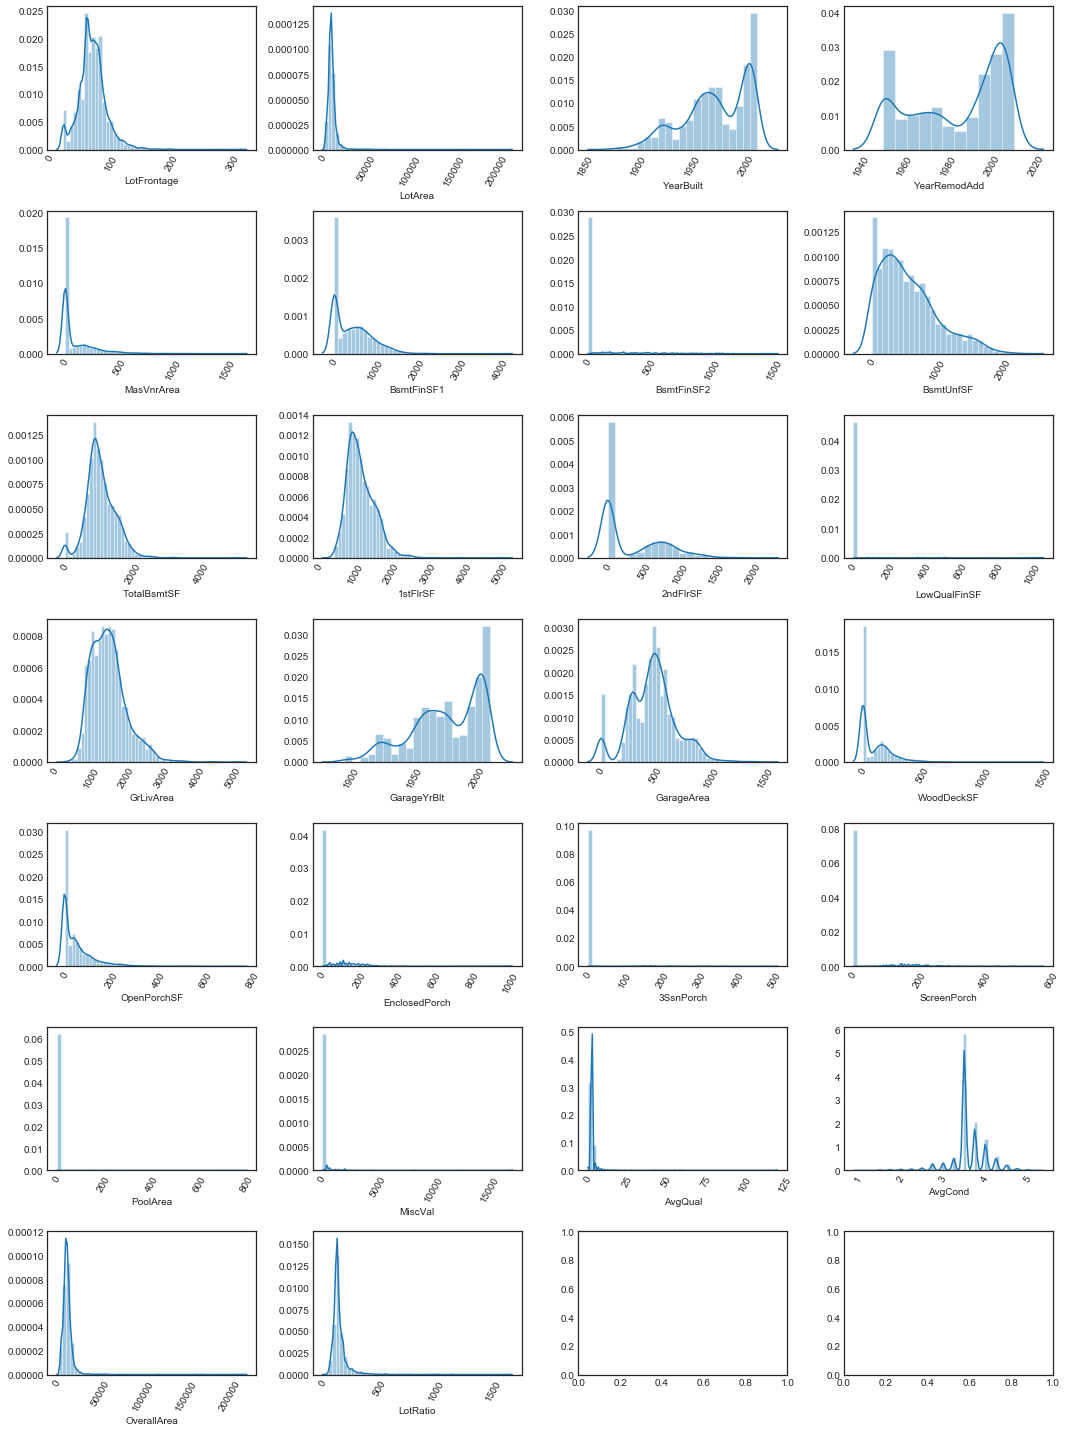

In [16]:
# inspect distributions of quantitatives including new ones
plot_cont_dists(nrows=7, ncols=4, data=quants_data.drop(columns=['SalePrice']), figsize=(15, 20))

In [17]:
# find minimum value over all quantitatives
quants_min_nonzero = quants_data[quants_data != 0].min().min()
print(f"Minimum quantitative value is {quants_data.min().min()}")
print(f"Minimum nonzero quantitative value is {quants_min_nonzero}")

Minimum quantitative value is 0.0
Minimum nonzero quantitative value is 0.4444444444444444


Since the minimum nonzero quantitative value is $< 1$, we must set $log(var) < log$ (`quants_min`) if $var = 0$ in order not to interfere with monotonicity

In [18]:
# Columns to log transform
log_cols = quants_data.columns.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'AvgCond'])
log_cols

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'AvgQual',
       'OverallArea', 'LotRatio'],
      dtype='object')

In [19]:
# log transform SalePrice
clean.data = log_transform(data=clean.data, log_cols=['SalePrice'])
drop.data = log_transform(data=drop.data, log_cols=['SalePrice'])

In [20]:
# log transform most quantitatives
clean_edit.data = log_transform(data=clean_edit.data, log_cols=log_cols)
drop_edit.data = log_transform(data=drop_edit.data, log_cols=log_cols)

## Model selection and tuning 

### Create modeling datasets

In [21]:
# set col kinds attribute of HPDataFramePlus attribute for model data method
do_col_kinds(drop)
do_col_kinds(drop_edit)
do_col_kinds(clean)
do_col_kinds(clean_edit)

In [22]:
# model data
mclean = HPDataFramePlus(data=clean.get_model_data(response='log_SalePrice'))
mclean_edit = HPDataFramePlus(data=clean_edit.get_model_data(response='log_SalePrice'))
mdrop = HPDataFramePlus(data=drop.get_model_data(response='log_SalePrice'))
mdrop_edit = HPDataFramePlus(data=drop_edit.get_model_data(response='log_SalePrice'))

In [23]:
mclean.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (train, 1) to (test, 2919)
Columns: 230 entries, LotFrontage to log_SalePrice
dtypes: float64(230)
memory usage: 5.2+ MB


In [24]:
mclean_edit.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (train, 1) to (test, 2919)
Columns: 222 entries, LotShape to log_SalePrice
dtypes: float64(222)
memory usage: 5.0+ MB


In [25]:
mdrop.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (train, 1) to (test, 2919)
Columns: 173 entries, LotFrontage to log_SalePrice
dtypes: float64(173)
memory usage: 4.0+ MB


In [26]:
mdrop_edit.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (train, 1) to (test, 2919)
Columns: 176 entries, LotShape to log_SalePrice
dtypes: float64(176)
memory usage: 4.0+ MB


### Compare default models for baseline

In [30]:
hpdfs = [mdrop, mclean, mdrop_edit, mclean_edit]
data_names = ['clean', 'clean_edit', 'drop', 'drop_edit']
response = 'log_SalePrice'
model_data = build_model_data(hpdfs, data_names, response)

First we'll look at a selection of untuned models with default parameters to get a rough idea of which ones might have better performance. 

We'll use root mean squared error (RMSE) for our loss function. Since we have a relatively small dataset, we'll use cross-validation to estimate rmse for test data.

In [72]:
def_models = fit_default_models(model_data, random_state=27)

In [38]:
# compare default models 
def_comp_df = compare_performance(def_models, model_data, random_state=27)
def_comp_df.sort_values(by=('clean', 'cv_rmse')).reset_index(drop=True)

data               model        clean             clean_edit            \
performance                train_rmse   cv_rmse   train_rmse   cv_rmse   
0                  ridge     0.099311  0.114057    0.0948572  0.115595   
1            bayes_ridge    0.0988284  0.114796    0.0950012  0.115103   
2                    xgb    0.0895599  0.124881    0.0853461  0.122171   
3                 plsreg     0.127452  0.132792     0.122064  0.128936   
4                    svr     0.123251  0.134915     0.122741  0.134896   
5                    mlp     0.116663  0.155852     0.129913  0.176163   
6                    knn     0.161079  0.203789     0.164677   0.20748   
7               dec_tree  2.52372e-05  0.209716  2.93011e-05  0.204794   
8             extra_tree  1.40429e-05  0.214345  2.26808e-05  0.206803   
9                  lasso     0.399557  0.399809     0.399557   0.40014   

data                drop              drop_edit            
performance   train_rmse   cv_rmse   train_rmse   cv_rmse  
0              0.0998434  0.115735     0.094225  0.113621  
1              0.0996576   0.11506     0.094478  0.113669  
2              0.0889219  0.125843    0.0876669  0.122144  
3               0.133912  0.139706     0.130416  0.136322  
4               0.123082   0.13465     0.120197  0.132023  
5               0.152254  0.183485     0.116909  0.175408  
6               0.153466  0.189674     0.153413  0.193834  
7            2.48969e-05  0.205676  3.15449e-05  0.201284  
8            1.87349e-05  0.206346  1.66016e-05  0.211453  
9               0.399557  0.399887     0.399557  0.399697

We note that `linear` (linear regression) had an extremely high cross-validation rmse estimate relative to the other models, although it did achieve roughly an order of magnitude improvement on the feature/selected engineered dataset `edit`. Since its estimated test performance is 8 orders of magnitude worse than the other models we'll drop it from consideration, and focus on the other models

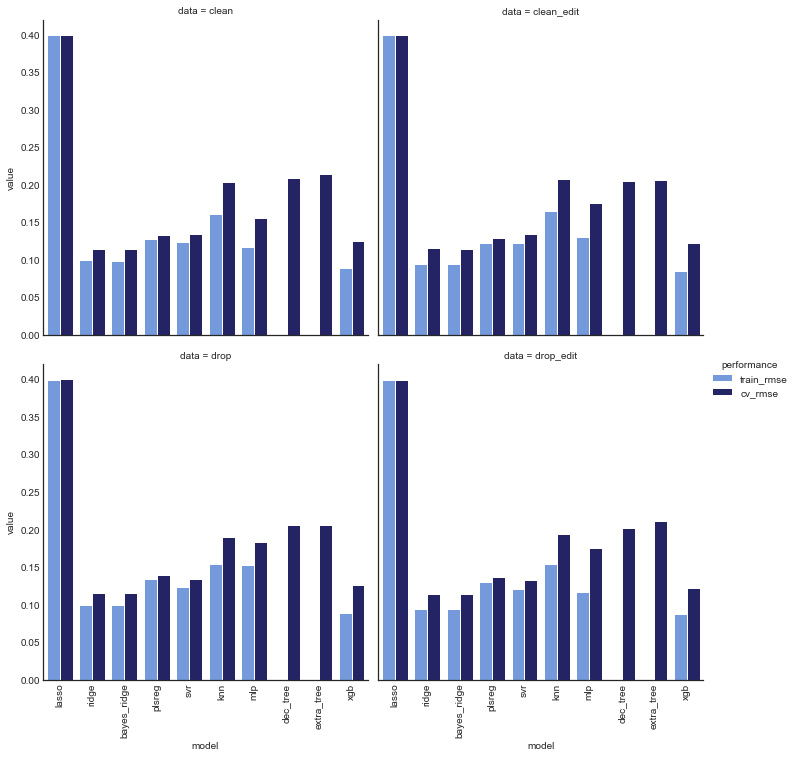

In [59]:
# compare train and cv performance for each dataset
data_palette = {'train_rmse': 'cornflowerblue', 'cv_rmse': 'midnightblue'}
plot_model_comp(def_comp_df, col='data', hue='performance', kind='bar',
                palette=data_palette, col_wrap=2)

Unsurprisingly, all models (with the exception of `lasso` regression) had worse CV error than train error. However, for some models the difference was much greater, and these are likely overfitting. In particular, `dec_tree`, `extra_tree` had cv error roughly 5 orders of magnitude greater than train error, and `mlp`, `knn`, and `xgb` also saw significant increases.

The other models (`ridge`, `bridge`, `pls` and `svr`) saw slighter differences in cv and train errors, and are thus less likely overfitting.

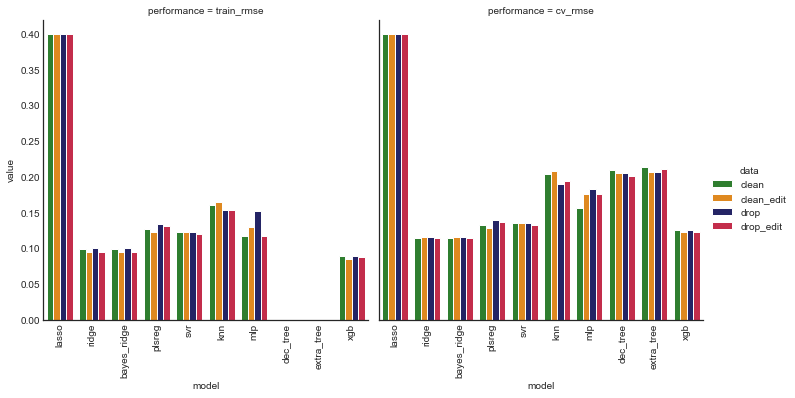

In [61]:
# compare train and cv error across datasets
perf_palette = {'drop': 'midnightblue', 'clean': 'forestgreen', 'drop_edit': 'crimson', 
           'clean_edit': 'darkorange'}
plot_model_comp(def_comp_df, col='performance', hue='data', kind='bar',
                palette=perf_palette)

It's interesting to note that, while there was a slight decrease for all models (with the exception of `knn`) in cv rmse when dropping features (i.e. performance on `drop`) the decrease was slight. In fact, for the best performing model, `ridge` (ridge regression) there was a slight improvement. The top two models `ridge` and `bridge` (Bayesian ridge regression) performed better when variables were dropped. This was expected, since these are both regularized linear models.

In [62]:
drop_cols = [(data_name, 'train_rmse') for data_name in data_names]
def_comp_df.drop(columns=drop_cols).sort_values(by=('clean', 'cv_rmse'))

data,model,clean,clean_edit,drop,drop_edit
performance,,cv_rmse,cv_rmse,cv_rmse,cv_rmse
1,ridge,0.114057,0.115595,0.115735,0.113621
2,bayes_ridge,0.114796,0.115103,0.11506,0.113669
9,xgb,0.124881,0.122171,0.125843,0.122144
3,plsreg,0.132792,0.128936,0.139706,0.136322
4,svr,0.134915,0.134896,0.13465,0.132023
6,mlp,0.155852,0.176163,0.183485,0.175408
5,knn,0.203789,0.20748,0.189674,0.193834
7,dec_tree,0.209716,0.204794,0.205676,0.201284
8,extra_tree,0.214345,0.206803,0.206346,0.211453


Almost all models had an improvement in cv rmse when features were added, so it appears the feature engineering was warranted. 

The top five models were consistent across all four versions of the dataset, namely `ridge`, `bridge`, `xgb`, `svr`, and `pls`, which are ridge, Bayesian ridge, gradient boosted decision tree, support vector and partial least squared regressors, respectively. Each of these saw an improvement when features were added, so we'll tune them on those versions of the data (`clean_edit` and `drop_edit`). Note that `xgb` and `pls` were slightly better on `clean_edit`, while `ridge`, `bridge`, and `svr` were slightly better on  `drop_edit`.

### Tune best individual models

Here we'll focus on tuning the most promising models from the [last section](#Compare-models). We'll use both `clean_edit` and `drop_edit` since some models performed better on the former and some on the latter.

In [74]:
# retain top 5 models
drop_models = ['lasso', 'dec_tree', 'extra_tree', 'knn', 'mlp']
models = remove_models(def_models, drop_models)
models.pop('clean')
models.pop('drop')
print(f'Promising models are {list(models["clean_edit"].keys())}')

Promising models are ['ridge', 'bayes_ridge', 'plsreg', 'svr', 'xgb']


In [78]:
# drop clean and drop versions of data
model_data.pop('clean')
model_data.pop('drop')

In [79]:
# train test input output for clean_edit (y_test values are NaN)
X_ce_train = model_data['clean_edit']['X_clean_edit_train']
X_ce_test = model_data['clean_edit']['X_clean_edit_test']
y_ce_train = model_data['clean_edit']['y_clean_edit_train']

# train test input output for drop_edit
X_de_train = model_data['drop_edit']['X_drop_edit_train']
X_de_test = model_data['drop_edit']['X_drop_edit_test']
y_de_train = model_data['drop_edit']['y_drop_edit_train']

#### Ridge regressor

[Ridge regression](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) is linear least squares with an $\ell_2$ regularization term.

##### Hyperparameter defaults for baseline

In [81]:
ridge_models = defaultdict(dict)
ridge_models['clean_edit']['ridge_ce_def'] = Ridge().fit(X_ce_train, y_ce_train)
ridge_models['drop_edit']['ridge_de_def'] = Ridge().fit(X_de_train, y_de_train)

##### Bayesian search with `hyperopt`

Bayesian hyperparameter optimization is an efficient tuning method. We'll optimize with respect to cv rmse

In [100]:
# ridge regression hyperparameters search space
ridge_space = {'alpha': hp.loguniform('alpha', low=-3*np.log(10), high=2*np.log(10))}

In [101]:
# optimize hyperparameters
_, ridge_ce_ho = ho_results(obj=ho_cv_rmse, space=ridge_space, est_name='ridge', 
                            X_train=X_ce_train, y_train=y_ce_train, 
                            max_evals=100, random_state=27)
_, ridge_de_ho = ho_results(obj=ho_cv_rmse, space=ridge_space, est_name='ridge', 
                            X_train=X_de_train, y_train=y_de_train, 
                            max_evals=100, random_state=27)

100%|██████████| 100/100 [00:08<00:00, 11.59it/s, best loss: 0.11253011002378797]


In [102]:
# fit models with optimal hyperparameters
ridge_models['clean_edit']['ridge_ce_tuned'] = Ridge(**ridge_ce_ho).fit(X_ce_train, y_ce_train)
ridge_models['drop_edit']['ridge_de_tuned'] = Ridge(**ridge_de_ho).fit(X_de_train, y_de_train)

In [115]:
# compare Ridge regression models
ridge_comp_df = compare_model_performance(ridge_models, model_data, random_state=27)
ridge_comp_df.sort_values(by='cv_rmse')

,model,train_rmse,cv_rmse
3,ridge_de_tuned,0.0950848,0.11253
2,ridge_de_def,0.094225,0.112878
1,ridge_ce_tuned,0.0956429,0.113467
0,ridge_ce_def,0.0948572,0.1137


The ridge regression model trained on the `drop_edit` dataset and tuned with Bayesian search had the best cv rmse. we not that it also had higher train rmse, which is promising (a lower train rmse might indicate overfitting).

Since ridge regression is just linear regression with a regularization term, it's relatively straightfoward to interpret. We'll rank the features of the best model their coefficient weights.

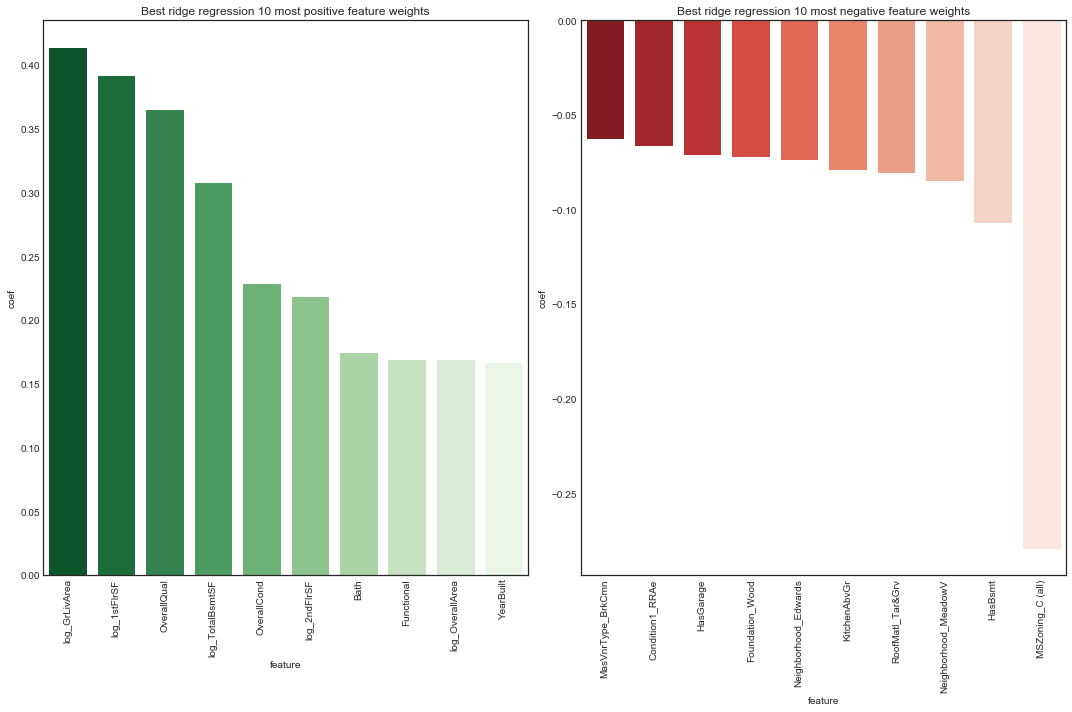

In [159]:
# Top and bottom 10 features in best ridge model
rank_features(ridge_models['drop_edit']['ridge_de_tuned'], 'ridge regression', X_de_train, 10,
             figsize=(15, 10), rotation=90)

The rankings of most positive feature weights are not too suprising. The most postively weighted feature was overall quality. We note condition variables and size variables are prominent. 

The rankings of most negative feature weights are perhaps more surprising, in particular the presence of a basement and number of kitchens. Interestingly, several neighborhoods stand out as having a negative association with sale price. The most negatively weighted feature was the property being zoned commericial. 

In [135]:
# replace default models with tuned models
models['clean_edit']['ridge'] = ridge_models['clean_edit']['ridge_ce_tuned']
models['drop_edit']['ridge'] = ridge_models['drop_edit']['ridge_de_tuned']

#### Bayesian Ridge regressor

[Bayesian ridge regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression)
is similar to ridge regression except it uses Bayesian methods to estimate the regularization parameter $\lambda$ from the data.

##### Hyperparameter defaults for baseline

In [136]:
bridge_models = defaultdict(dict)
bridge_models['clean_edit']['bridge_ce_def'] = BayesianRidge().fit(X_ce_train, y_ce_train)
bridge_models['drop_edit']['bridge_de_def'] = BayesianRidge().fit(X_de_train, y_de_train)

##### Bayesian search

In [145]:
# bayesian ridge regression hyperparameter space
bridge_space = {'alpha_1': hp.loguniform('alpha_1', low=-9*np.log(10), high=3*np.log(10)),
                'alpha_2': hp.loguniform('alpha_2', low=-9*np.log(10), high=3*np.log(10)),
                'lambda_1': hp.loguniform('lambda_1', low=-9*np.log(10), high=3*np.log(10)),
                'lambda_2': hp.loguniform('lambda_2', low=-9*np.log(10), high=3*np.log(10))}

In [150]:
def ho_cv_rmse(search_params, X_train, y_train, fixed_params={},
               est_name='bayes_ridge', n_splits=5, shuffle=True,
               random_state=None):
    """CV rmse objective function for hyperopt parameter search."""
    if est_name == 'ridge':
        est = Ridge(**{**search_params, **fixed_params})
    elif est_name == 'bridge':
        est = BayesianRidge(**{**search_params, **fixed_params})
    elif est_name == 'pls':
        est = PLSRegression(**{**search_params, **fixed_params})
    elif est_name == 'svr':
        est = SVR(**{**search_params, **fixed_params})
    elif est_name == 'xgb':
        est = XGBRegressor(**{**search_params, **fixed_params},
                           objective='reg:squarederror',
                           random_state=random_state, n_jobs=-1)
    est.fit(X_train, y_train)
    _, cv_rmse = rmse(model=est, X_train=X_train, y_train=y_train,
                      n_splits=n_splits, shuffle=shuffle,
                      random_state=random_state)
    return cv_rmse

def ho_results(obj, space, est_name, X_train, y_train,
               fixed_params={}, max_evals=10,
               n_splits=5, shuffle=True, random_state=None):
    """Hyperopt parameter search results."""
    fn = partial(obj, X_train=X_train, y_train=y_train,
                 fixed_params=fixed_params, est_name=est_name,
                 n_splits=n_splits, shuffle=shuffle,
                 random_state=random_state)
    trials = Trials()
    params = fmin(fn=fn, space=space, algo=tpe.suggest, trials=trials,
                  max_evals=max_evals)
    return trials, params

In [151]:
# optimize hyperparameters
_, bridge_ce_ho = ho_results(obj=ho_cv_rmse, space=bridge_space, est_name='bridge', 
                             X_train=X_ce_train, y_train=y_ce_train, 
                             max_evals=100, random_state=27)
_, bridge_de_ho = ho_results(obj=ho_cv_rmse, space=bridge_space, est_name='bridge', 
                             X_train=X_de_train, y_train=y_de_train, 
                             max_evals=100, random_state=27)

100%|██████████| 100/100 [00:36<00:00,  2.76it/s, best loss: 0.11255821429868541]


In [153]:
# fit models with optimal hyperparameters
bridge_models['clean_edit']['bridge_ce_tuned'] = BayesianRidge(**bridge_ce_ho).fit(X_ce_train, y_ce_train)
bridge_models['drop_edit']['bridge_de_tuned'] = BayesianRidge(**bridge_de_ho).fit(X_de_train, y_de_train)

In [154]:
# compare Ridge regression models
bridge_comp_df = compare_model_performance(bridge_models, model_data, random_state=27)
bridge_comp_df.sort_values(by='cv_rmse')

,model,train_rmse,cv_rmse
3,bridge_de_tuned,0.0944518,0.112558
2,bridge_de_def,0.094478,0.112793
1,bridge_ce_tuned,0.0955734,0.1135
0,bridge_ce_def,0.0950012,0.113674


As with ordinary ridge regression, the Bayesian ridge model trained on the `drop_edit` data and tuned with Bayesian search had the best cv rmse.

As with ridge regression, the model is straightforward to interpret.

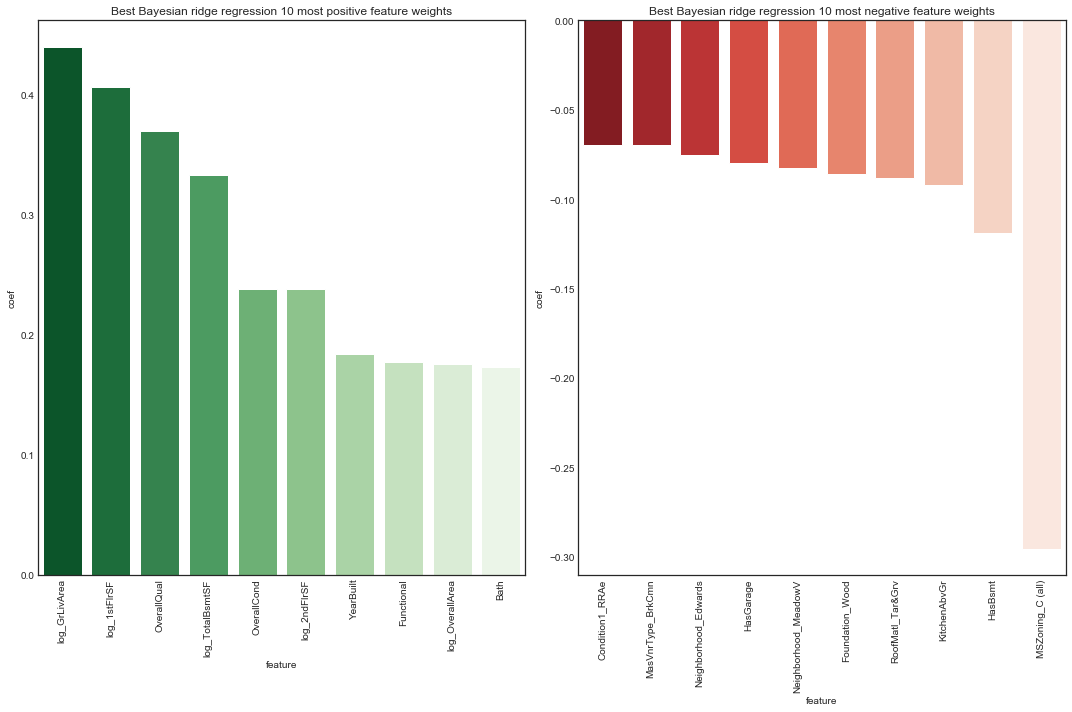

In [160]:
# Top and bottom 10 features in best Bayesian ridge model
rank_features(bridge_models['drop_edit']['bridge_de_tuned'], 'Bayesian ridge regression', X_de_train, 10,
             figsize=(15, 10), rotation=90)

Feature weight rankings are nearly identical to the ridge model.

In [161]:
# replace default models with tuned models
models['clean_edit']['bridge'] = bridge_models['clean_edit']['bridge_ce_tuned']
models['drop_edit']['bridge'] = bridge_models['drop_edit']['bridge_de_tuned']

#### Partial Least Squares regressor

[Partial least squares regression](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html) stands out among the other models we're tuning here as the only dimensional reduction method. It is [well-suited to multicollinearity in the input data](https://scikit-learn.org/stable/modules/cross_decomposition.html#cross-decomposition).

##### Hyperparameter defaults for baseline

In [162]:
pls_models = defaultdict(dict)
pls_models['clean_edit']['pls_ce_def'] = PLSRegression().fit(X_ce_train, y_ce_train)
pls_models['drop_edit']['pls_de_def'] = PLSRegression().fit(X_de_train, y_de_train)

##### Bayesian search

The main hyperparameter of interest in partial least squared is the number of components (analogous to the number of components in principal component analysis) which is essentially the number of dimensions of the reduced dataset.

In [163]:
# partial least squares hyperparameter spaces
pls_ce_space = {'max_iter': ho_scope.int(hp.quniform('max_iter', low=200, high=10000, q=10)),
               'n_components': ho_scope.int(hp.quniform('n_components', low=2, high=X_ce_train.shape[1] - 2, q=1))
                }
pls_de_space = {'max_iter': ho_scope.int(hp.quniform('max_iter', low=200, high=10000, q=10)),
               'n_components': ho_scope.int(hp.quniform('n_components', low=2, high=X_de_train.shape[1] - 2, q=1))}

In [164]:
# optimize hyperparameters
_, pls_ce_ho = ho_results(obj=ho_cv_rmse, space=pls_ce_space, max_evals=100, est_name='pls', 
                            X_train=X_ce_train, y_train=y_ce_train, random_state=27)
_, pls_de_ho = ho_results(obj=ho_cv_rmse, space=pls_de_space, max_evals=100, est_name='pls', 
                            X_train=X_de_train, y_train=y_de_train, random_state=27)

100%|██████████| 100/100 [01:58<00:00,  1.19s/it, best loss: 0.11628329440486905]


In [ ]:
# workaround to cast results of hyperopt param search to correct type
conv_params = ['max_iter', 'n_components']
pls_ce_ho = convert_to_int(pls_ce_ho, conv_params)
pls_de_ho = convert_to_int(pls_de_ho, conv_params)

# fit models with optimal hyperparameters
pls_models['clean_edit']['pls_ce_tuned'] = PLSRegression(**pls_ce_ho).fit(X_ce_train, y_ce_train)
pls_models['drop_edit']['pls_de_tuned'] = PLSRegression(**pls_de_ho).fit(X_de_train, y_de_train)

In [ ]:
# inspect pls optimal parameters
print(f'On the clean_edit data, optimal PLS parameters are {pls_ce_ho}')
print(f'On the drop_edit data, optimal PLS parameters are {pls_de_ho}')

Interestingly, only a small number of components were deemed optimal! It's worth recalling that this likely reflects a local minimum in the loss function, so the result should be taken with a grain of salt. However, it is interesting to note that such a low number of components are sufficient to get a competitive model.

In [ ]:
# compare Bayesian Ridge models on clean and edit datasets
pls_comp_df = compare_model_performance(pls_models, model_data, 'bridge')
pls_comp_df.sort_values(by='cv_rmse').reset_index(drop=True)

As with ridge and Bayesian ridge regression, partial least squares lower cv error on the `drop_edit` dataset. The cv rmse estimate is very close and again its remarkable that only 5 components are required!

In [ ]:
# replace default models with tuned models
models['clean_edit']['pls'] = pls_models['clean_edit']['pls_ce_tuned']
models['drop_edit']['pls'] = pls_models['drop_edit']['pls_de_tuned']

#### Support Vector regressor

##### Hyperparameter defaults for baseline

In [166]:
svr_models = defaultdict(dict)
svr_models['clean_edit']['svr_ce_def'] = SVR().fit(X_ce_train, y_ce_train)
svr_models['drop_edit']['svr_de_def'] = SVR().fit(X_de_train, y_de_train)

##### Bayesian search

In [159]:
# hyperparameter space for SVR with rbf kernel
svr_space = {'gamma': hp.loguniform('gamma', low=-3*np.log(10), high=2*np.log(10)),
             'C': hp.loguniform('C', low=-3*np.log(10), high=2*np.log(10)),
             'epsilon': hp.loguniform('epsilon', low=-3*np.log(10), high=2*np.log(10))
            }

In [160]:
# optimize hyperparameters
_, svr_ce_ho = ho_results(obj=ho_cv_rmse, space=svr_space, max_evals=50, est_name='svr', 
                              X_train=X_ce_train, y_train=y_ce_train, random_state=27)
_, svr_de_ho = ho_results(obj=ho_cv_rmse, space=svr_space, max_evals=50, est_name='svr', 
                              X_train=X_de_train, y_train=y_de_train, random_state=27)

100%|██████████| 50/50 [01:38<00:00,  1.97s/it, best loss: 0.11001018195046919]


In [161]:
# fit models with optimal hyperparameters
svr_models['clean_edit']['svr_ce_tuned'] = SVR(**svr_ce_ho).fit(X_ce_train, y_ce_train)
svr_models['drop_edit']['svr_de_tuned'] = SVR(**svr_de_ho).fit(X_de_train, y_de_train)

In [164]:
# compare SVR model performance on clean and edit datasets
svr_comp_df = compare_model_performance(svr_models, model_data, 'svr')
svr_comp_df.sort_values(by='cv_rmse').reset_index(drop=True)

,index,train_rmse,cv_rmse
0,svr_de_tuned,0.0880258,0.109859
1,svr_ce_tuned,0.0777329,0.113234
2,svr_de_def,0.114054,0.126171
3,svr_ce_def,0.117089,0.130044


As with all previous models, we're seeing better performance on `drop_edit`. Again, a higher train rmse on `drop_edit` but a lower cv rmse is a positive sign.

In [248]:
# replace default models with tuned models
models['clean_edit']['svr'] =svr_models['clean_edit']['svr_ce_tuned']
models['drop_edit']['svr'] = svr_models['drop_edit']['svr_de_tuned']

####  Gradient boosted trees regressor

##### Hyperparameter defaults for baseline

In [192]:
xgb_models = defaultdict(dict)
xgb_models['clean_edit']['xgb_ce_def'] = XGBRegressor(objective='reg:squarederror', random_state=27, n_jobs=-1)
xgb_models['drop_edit']['xgb_de_def'] = XGBRegressor(objective='reg:squarederror', random_state=27, n_jobs=-1)
xgb_models['clean_edit']['xgb_ce_def'].fit(X_ce_train.values, y_ce_train.values)
xgb_models['drop_edit']['xgb_de_def'].fit(X_de_train.values, y_de_train.values)

[17:12:02] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:04] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=27,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

##### Bayesian search

In [336]:
# hyperparameter spaces
xgb_space = {'max_depth': ho_scope.int(hp.quniform('max_depth', low=1, high=3, q=1)),
             'n_estimators': ho_scope.int(hp.quniform('n_estimators', low=100, high=500, q=50)),
             'learning_rate': hp.loguniform('learning_rate', low=-4*np.log(10), high=0),
             'gamma': hp.loguniform('gamma', low=-3*np.log(10), high=2*np.log(10)),
             'min_child_weight': ho_scope.int(hp.quniform('min_child_weight', low=1, high=7, q=1)),
             'subsample': hp.uniform('subsample', low=0.25, high=1),
             'colsample_bytree': hp.uniform('colsample_bytree', low=0.25, high=1),
             'colsample_bylevel': hp.uniform('colsample_bylevel', low=0.25, high=1),
             'colsample_bynode': hp.uniform('colsample_bynode', low=0.25, high=1),
             'reg_lambda': hp.loguniform('reg_lambda', low=-2*np.log(10), high=2*np.log(10)),
             'reg_alpha': hp.loguniform('reg_alpha', low=-1*np.log(10), high=1*np.log(10)),
            }

fixed_params = {'objective': 'reg:squarederror',
                'n_jobs': -1,
                'random_state': 27,
               }

In [171]:
# optimize hyperparameters
_, xgb_ce_ho = ho_results(obj=ho_cv_rmse, space=xgb_space, max_evals=50, est_name='xgb',
                         X_train=X_ce_train, y_train=y_ce_train,  fixed_params=fixed_params, 
                         random_state=27)
_, xgb_de_ho = ho_results(obj=ho_cv_rmse, space=xgb_space, max_evals=50, est_name='xgb',
                         X_train=X_de_train, y_train=y_de_train,  fixed_params=fixed_params,
                         random_state=27)

100%|██████████| 50/50 [08:27<00:00, 10.15s/it, best loss: 0.11980063936079628]


In [196]:
# convert params to int
conv_params = ['max_depth', 'min_child_weight', 'n_estimators']
xgb_ce_ho = convert_to_int(xgb_ce_ho, conv_params)
xgb_de_ho = convert_to_int(xgb_de_ho, conv_params)

# fit models with optimal hyperparameters
xgb_models['clean_edit']['xgb_ce_tuned'] = XGBRegressor(**{**xgb_ce_ho, **fixed_params})
xgb_models['drop_edit']['xgb_de_tuned'] = XGBRegressor(**{**xgb_de_ho, **fixed_params})
xgb_models['clean_edit']['xgb_ce_tuned'].fit(X_ce_train.values, y_ce_train.values)
xgb_models['drop_edit']['xgb_de_tuned'].fit(X_de_train.values, y_de_train.values)

[17:13:30] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:33] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.5672648925165988,
             colsample_bynode=0.5893345618435389,
             colsample_bytree=0.41493266068453943, gamma=0.0016461487220787736,
             importance_type='gain', learning_rate=0.20220059542463079,
             max_delta_step=0, max_depth=3, min_child_weight=4, missing=None,
             n_estimators=250, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.8977783352683452,
             reg_lambda=0.21619035463070696, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.850063763831314, verbosity=1)

In [198]:
# compare XGBoost models on clean_edit and drop_edit datasets
xgb_comp_df = compare_model_performance(xgb_models, model_data, 'xgb')
xgb_comp_df.sort_values(by='cv_rmse').reset_index(drop=True)

,index,train_rmse,cv_rmse
0,xgb_ce_tuned,0.0866096,0.114289
1,xgb_de_tuned,0.0734979,0.120353
2,xgb_ce_def,0.0857011,0.12106
3,xgb_de_def,0.0867225,0.123224


In contrast to all previous models, the gradient boosted tree regressor had a lower cv rmse on `clean_edit`, but similarly to previous models train rmse was higher.

We can rank the features by importance (in this case, the number of times the feature was used to split a tree across all trees in the forest).

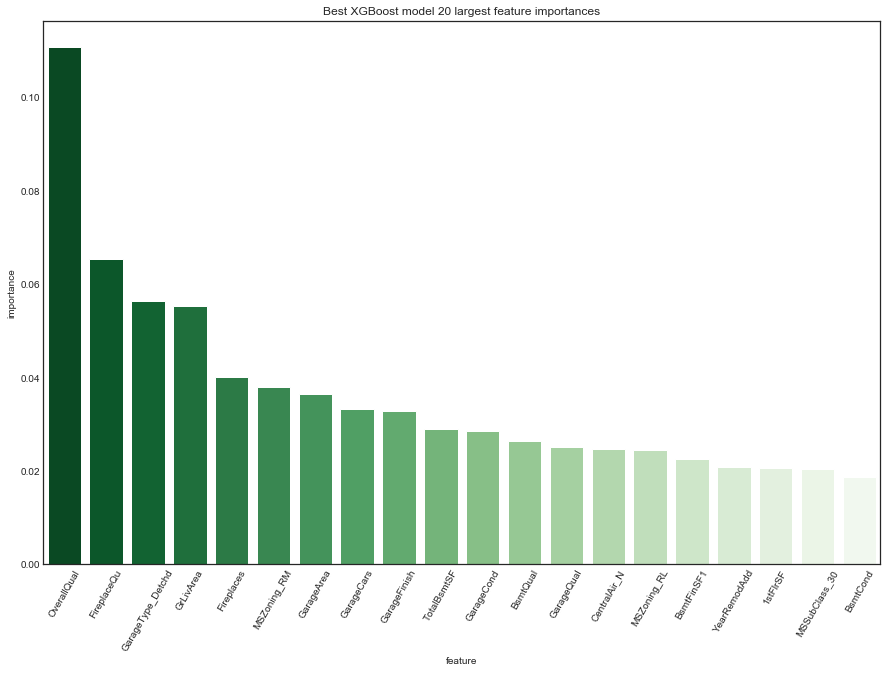

In [201]:
rank_xgb_features(xgb_models['clean_edit']['xgb_ce_tuned'], X_ce_train, 20)

In [249]:
# replace default models with tuned models
models['clean_edit']['xgb'] = xgb_models['clean_edit']['xgb_ce_tuned']
models['drop_edit']['xgb'] = xgb_models['drop_edit']['xgb_de_tuned']

#### Compare tuned models and save parameters

In [250]:
# compare results of tuned models
tuned_comp_df = compare_performance(models, model_data, random_state=27)
tuned_comp_df.sort_values(by=('clean_edit', 'cv_rmse')).reset_index(drop=True)

data          model clean_edit            drop_edit          
performance         train_rmse   cv_rmse train_rmse   cv_rmse
0               svr  0.0777329  0.113234  0.0880258  0.109859
1             ridge  0.0963162  0.113369    0.09455   0.11171
2            bridge  0.0960203   0.11343  0.0938855    0.1118
3               xgb  0.0866096  0.114289  0.0734979  0.120353
4               pls  0.0975016  0.117229  0.0982632  0.114756

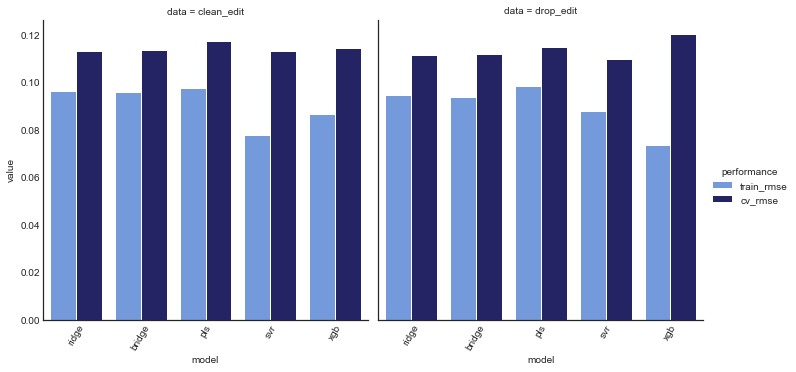

In [251]:
# compare tuned model train and cv performance on clean and edit datasets
plot_model_comp(tuned_comp_df, col='data', hue='performance', 
                palette=data_palette)

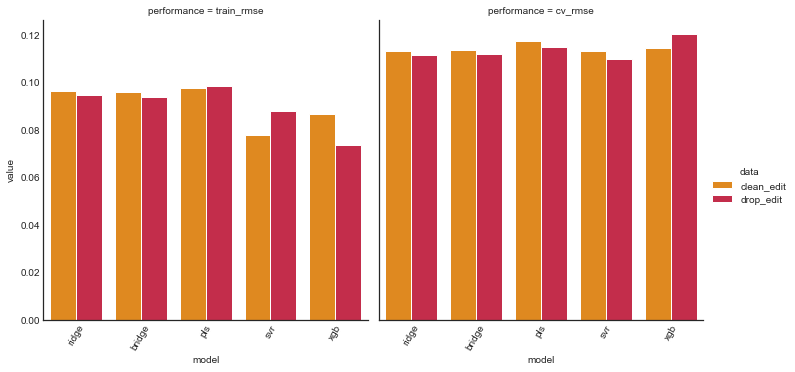

In [252]:
# compare clean and edit performance for train and cv error
palette = {'clean': 'midnightblue', 'edit': 'cornflowerblue'}
plot_model_comp(tuned_comp_df, col='performance', hue='data', 
                palette=perf_palette)

In [263]:
# save tuned parameters in JSON format
save_tuned_params(models, '../data/tuned_params.json')

### Ensembles

First we reinstantiate the tuned models from the last section from the saved parameters

In [268]:
models = models_from_params('../data/tuned_params')

#### Voting

Unfortunately `sklearn.PLSRegressor`'s `predicrt` method returns arrays of size `(n_samples, 1)` rather than `(n_samples,)` like all all other models. This throws an error when passed as in estimator ito `cross_val_score` so we'll drop it from consideration. We'll also drop `bridge` since its feature weights were nearly identical to `ridge`. 

In [297]:
# Voting ensemble of all models except pls due to broadcast error in cross_val_score
voters_ce = [model for model in models['clean_edit'].items() if model[0] not in ['pls', 'bridge']]
voters_de = [model for model in models['drop_edit'].items() if model[0] not in ['pls', 'bridge']]

# uniform weights for tuned models 
ensembles = defaultdict(dict)
ensembles['clean_edit']['voter_def'] = VotingRegressor(voters_ce, n_jobs=-1)
ensembles['drop_edit']['voter_def'] = VotingRegressor(voters_de, n_jobs=-1)
ensembles['clean_edit']['voter_def'].fit(X_ce_train.values, y_ce_train.values)
ensembles['drop_edit']['voter_def'].fit(X_de_train.values, y_de_train.values)

VotingRegressor(estimators=[('ridge',
                             Ridge(alpha=2.7319995655902547, copy_X=True,
                                   fit_intercept=True, max_iter=None,
                                   normalize=False, random_state=None,
                                   solver='auto', tol=0.001)),
                            ('svr',
                             SVR(C=54.755680435313145, cache_size=200,
                                 coef0=0.0, degree=3,
                                 epsilon=0.028799094254409442,
                                 gamma=0.0010271102795770723, kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verb...
                                          importance_type='gain',
                                          learning_rate=0.20220059542463079,
                                          max_delta_step=0, max_depth=3,
                                          min_child_we

In [300]:
# voting ensemble hyperparameters
voter_space = {'voter1': hp.uniform('voter1', low=0, high=1),
               'voter2': hp.uniform('voter2', low=0, high=1),
               'voter3': hp.uniform('voter3', low=0, high=1)
              }

fixed_params = {'n_jobs': -1,
                'random_state': 27,
               }

In [301]:
# optimize hyperparameters
voter_ce_ho_trials, voter_ce_ho = ho_ens_results(obj=ho_ens_cv_rmse, space=voter_space, max_evals=50,
                                                 ens=voters_ce, ens_name='voter', 
                                                 X_train=X_ce_train, y_train=y_ce_train, 
                                                 fixed_params=fixed_params, random_state=27)
voter_de_ho_trials, voter_de_ho = ho_ens_results(obj=ho_ens_cv_rmse, space=voter_space, max_evals=50,
                                                 ens=voters_de, ens_name='voter', 
                                                 X_train=X_de_train, y_train=y_de_train,
                                                 fixed_params=fixed_params, random_state=27)

100%|██████████| 50/50 [08:27<00:00, 10.16s/it, best loss: 0.1084570573345616] 


In [305]:
# add and fit tuned voting ensembles
ensembles['clean_edit']['voter_tuned'] = VotingRegressor(voters_ce, weights=list(voter_ce_ho.values()))
ensembles['drop_edit']['voter_tuned'] = VotingRegressor(voters_de, weights=list(voter_de_ho.values()))
ensembles['clean_edit']['voter_tuned'].fit(X_ce_train.values, y_ce_train.values)
ensembles['drop_edit']['voter_tuned'].fit(X_de_train.values, y_de_train.values)

[18:52:44] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:52:48] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


VotingRegressor(estimators=[('ridge',
                             Ridge(alpha=2.7319995655902547, copy_X=True,
                                   fit_intercept=True, max_iter=None,
                                   normalize=False, random_state=None,
                                   solver='auto', tol=0.001)),
                            ('svr',
                             SVR(C=54.755680435313145, cache_size=200,
                                 coef0=0.0, degree=3,
                                 epsilon=0.028799094254409442,
                                 gamma=0.0010271102795770723, kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verb...
                                          max_delta_step=0, max_depth=3,
                                          min_child_weight=4, missing=None,
                                          n_estimators=250, n_jobs=1,
                                          nthread=N

#### Stacking

##### Default base and meta

In [353]:
# add and fit stacks with default models for base and meta
def_models = create_def_models()
ensembles = add_stack_reg(ensembles, def_models, model_data, random_state=27, tuned='def')

# add and fit stacks with default models for base and meta with base features going to meta
def_models = create_def_models()
ensembles = add_stack_reg(ensembles, def_models, model_data, random_state=27, tuned='def_second',
                          use_features_in_secondary=True)

##### Pretuned base and meta

In [354]:
# add and fit stacks with pretuned base and meta models
ensembles = add_stack_reg(ensembles, models, model_data, random_state=27, tuned='pretuned')

# add and fit stacks with pretuned base and meta models
ensembles = add_stack_reg(ensembles, models, model_data, random_state=27, tuned='pretuned_secondary',
                          use_features_in_secondary=True)

[20:58:29] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:58:40] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:58:52] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:03] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:14] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:15] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is n

##### Tuned stack

In [341]:
# stacking regressor hyperparameter spaces
ridge_base_space = {'alpha': hp.loguniform('alpha_ridge', low=-3*np.log(10), high=2*np.log(10))}
svr_base_space = {'gamma': hp.loguniform('gamma_svr', low=-3*np.log(10), high=2*np.log(10)),
                  'C': hp.loguniform('C_svr', low=-3*np.log(10), high=2*np.log(10)),
                  'epsilon': hp.loguniform('epsilon_svr', low=-3*np.log(10), high=2*np.log(10))}
xgb_base_space = {'max_depth': ho_scope.int(hp.quniform('max_depth_xgb', low=1, high=3, q=1)),
                  'n_estimators': ho_scope.int(hp.quniform('n_estimators_xgb', low=100, high=500, q=50)),
                  'learning_rate': hp.loguniform('learning_rate_xgb', low=-4*np.log(10), high=0),
                  'gamma': hp.loguniform('gamma_xgb', low=-3*np.log(10), high=2*np.log(10)),
                  'min_child_weight': ho_scope.int(hp.quniform('min_child_weight_xgb', low=1, high=7, q=1)),
                  'subsample': hp.uniform('subsample_xgb', low=0.25, high=1),
                  'colsample_bytree': hp.uniform('colsample_bytree_xgb', low=0.25, high=1),
                  'colsample_bylevel': hp.uniform('colsample_bylevel_xgb', low=0.25, high=1),
                  'colsample_bynode': hp.uniform('colsample_bynode_xgb', low=0.25, high=1),
                  'reg_lambda': hp.loguniform('reg_lambda_xgb', low=-2*np.log(10), high=2*np.log(10)),
                  'reg_alpha': hp.loguniform('reg_alpha_xgb', low=-1*np.log(10), high=1*np.log(10)),
                 }
stack_space = {'ridge': ridge_base_space, 'svr': svr_base_space, 'xgb': xgb_base_space}
meta_space = [{'ridge': {'alpha': hp.loguniform('alpha_ridge_meta', low=-3*np.log(10), high=2*np.log(10))
                        }
              },
              {'svr': {'kernel': 'rbf',
                       'gamma': hp.loguniform('gamma_svr_meta', low=-3*np.log(10), high=2*np.log(10)),
                       'C': hp.loguniform('C_svr_meta', low=-3*np.log(10), high=2*np.log(10)),
                       'epsilon': hp.loguniform('epsilon_svr_meta', low=-3*np.log(10), high=2*np.log(10))
                      }
              },
              {'xgb': {'max_depth': ho_scope.int(hp.quniform('max_depth_xgb_meta', low=1, high=3, q=1)),
                       'n_estimators': ho_scope.int(hp.quniform('n_estimators_xgb_meta', low=100, high=500, q=50)),
                       'learning_rate': hp.loguniform('learning_rate_xgb_meta', low=-4*np.log(10), high=0),
                       'gamma': hp.loguniform('gamma_xgb_meta', low=-3*np.log(10), high=2*np.log(10)),
                       'min_child_weight': ho_scope.int(hp.quniform('min_child_weight_xgb_meta', low=1, high=7, q=1)),
                       'subsample': hp.uniform('subsample_xgb_meta', low=0.25, high=1),
                       'colsample_bytree': hp.uniform('colsample_bytree_xgb_meta', low=0.25, high=1),
                       'colsample_bylevel': hp.uniform('colsample_bylevel_xgb_meta', low=0.25, high=1),
                       'colsample_bynode': hp.uniform('colsample_bynode_xgb_meta', low=0.25, high=1),
                       'reg_lambda': hp.loguniform('reg_lambda_xgb_meta', low=-2*np.log(10), high=2*np.log(10)),
                       'reg_alpha': hp.loguniform('reg_alpha_xgb_meta', low=-1*np.log(10), high=1*np.log(10))
                     }
                }  
             ]
stack_space['meta'] = hp.choice('meta', meta_space)

In [359]:
# tune stack without secondary
_, stack_ce_ho = ho_stack_results(obj=ho_stack_cv_rmse, space=stack_space, max_evals=50, 
                                  X_train=X_ce_train, y_train=y_ce_train, random_state=27)
_, stack_de_ho = ho_stack_results(obj=ho_stack_cv_rmse, space=stack_space, max_evals=50,
                                  X_train=X_de_train, y_train=y_de_train, random_state=27)

100%|██████████| 50/50 [1:13:54<00:00, 88.70s/it, best loss: 0.11046250109579624] 


In [360]:
# tune stack with secondary
_, stack_ce_ho_sec = ho_stack_results(obj=ho_stack_cv_rmse, space=stack_space, max_evals=50, 
                                      X_train=X_ce_train, y_train=y_ce_train, random_state=27,
                                      use_features_in_secondary=True)
_, stack_de_ho_sec = ho_stack_results(obj=ho_stack_cv_rmse, space=stack_space, max_evals=50,
                                      X_train=X_de_train, y_train=y_de_train, random_state=27,
                                      use_features_in_secondary=True)

100%|██████████| 50/50 [37:58<00:00, 45.58s/it, best loss: 0.11101380494558001]


In [361]:
# add and fit tuned stacks
ensembles['clean_edit']['stack_tuned'] = stack_from_ho_results(stack_ce_ho, 27)
ensembles['drop_edit']['stack_tuned'] = stack_from_ho_results(stack_de_ho, 27)
ensembles['clean_edit']['stack_tuned'].fit(X_ce_train, y_ce_train)
ensembles['drop_edit']['stack_tuned'].fit(X_de_train, y_de_train)

StackingCVRegressor(cv=5,
                    meta_regressor=Ridge(alpha=0.2819504320648807, copy_X=True,
                                         fit_intercept=True, max_iter=None,
                                         normalize=False, random_state=None,
                                         solver='auto', tol=0.001),
                    n_jobs=None, pre_dispatch='2*n_jobs', random_state=27,
                    refit=True,
                    regressors=[Ridge(alpha=2.340572018624484, copy_X=True,
                                      fit_intercept=True, max_iter=None,
                                      normalize=False, random_st...
                                             max_delta_step=0, max_depth=3,
                                             min_child_weight=6, missing=None,
                                             n_estimators=350, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:s

In [362]:
# add and fit tuned stacks with 
ensembles['clean_edit']['stack_tuned_secondary'] = stack_from_ho_results(stack_ce_ho_sec, 27)
ensembles['drop_edit']['stack_tuned_secondary'] = stack_from_ho_results(stack_de_ho_sec, 27)
ensembles['clean_edit']['stack_tuned_secondary'].fit(X_ce_train, y_ce_train)
ensembles['drop_edit']['stack_tuned_secondary'].fit(X_de_train, y_de_train)

StackingCVRegressor(cv=5,
                    meta_regressor=Ridge(alpha=2.173999236114392, copy_X=True,
                                         fit_intercept=True, max_iter=None,
                                         normalize=False, random_state=None,
                                         solver='auto', tol=0.001),
                    n_jobs=None, pre_dispatch='2*n_jobs', random_state=27,
                    refit=True,
                    regressors=[Ridge(alpha=1.2122191253034325, copy_X=True,
                                      fit_intercept=True, max_iter=None,
                                      normalize=False, random_st...
                                             min_child_weight=1, missing=None,
                                             n_estimators=400, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:squarederror',
                                             random_state=27,


##### Compare ensembles

In [363]:
# compare results of tuned models
ens_comp_df = compare_performance(ensembles, model_data, random_state=27)
ens_comp_df.sort_values(by=('drop_edit', 'cv_rmse')).reset_index(drop=True)

data                                       model clean_edit            \
performance                                      train_rmse   cv_rmse   
0                                    voter_tuned  0.0791426  0.109072   
1                      stack_ridge_meta_pretuned  0.0835174  0.108937   
2                                      voter_def  0.0828417  0.109019   
3              stack_svr_meta_pretuned_secondary  0.0756126  0.110708   
4                        stack_svr_meta_pretuned  0.0827698  0.109407   
5                           stack_ridge_meta_def  0.0883217  0.110268   
6                             stack_svr_meta_def  0.0902724  0.111347   
7                                    stack_tuned  0.0953309  0.112314   
8            stack_ridge_meta_pretuned_secondary  0.0863259  0.111278   
9                          stack_tuned_secondary   0.094904  0.114143   
10                   stack_ridge_meta_def_second  0.0888463  0.111574   
11                     stack_xgb_meta_def_second  0.0799797  0.113577   
12             stack_xgb_meta_pretuned_secondary  0.0770047  0.111977   
13                     stack_svr_meta_def_second  0.0976487   0.11657   
14                       stack_xgb_meta_pretuned  0.0879998  0.116314   
15                            stack_xgb_meta_def  0.0938021  0.116166   

data         drop_edit            
performance train_rmse   cv_rmse  
0            0.0825242  0.108134  
1            0.0839546   0.10851  
2            0.0814688  0.108523  
3            0.0834208  0.108543  
4             0.083613  0.108873  
5            0.0882481  0.109506  
6            0.0907135  0.109981  
7            0.0910515  0.110427  
8            0.0861656  0.110913  
9            0.0937061  0.110918  
10           0.0894194  0.110976  
11            0.076563  0.113861  
12           0.0714007  0.114887  
13           0.0970647  0.115374  
14            0.088159  0.115611  
15           0.0907849   0.11857

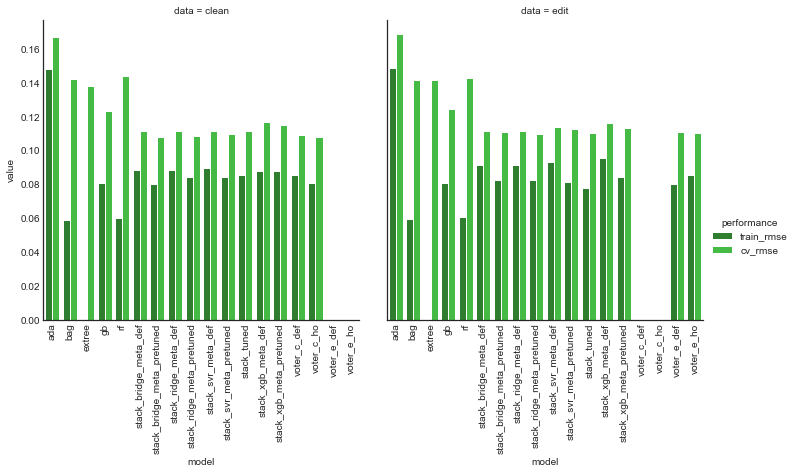

In [409]:
# compare tuned model train and cv performance on clean 
plot_model_comp(ens_comp_df, col='data', hue='performance', palette=data_palette, rotation=90)

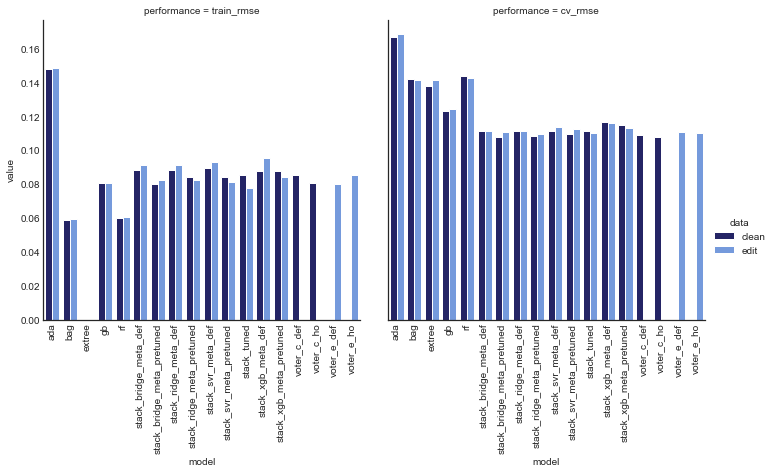

In [411]:
# compare clean and edit performance for train and cv error
plot_model_comp(ens_comp_df, col='performance', hue='data', palette=perf_palette, rotation=90)

## Predict and Evaluate

To check our test prediction performance we need to submit to Kaggle. We'll submit predictions for the top 5 ensembles models for both version of the data (`clean_edit` and `drop_edit`) and report them here.